In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch

Making a Generator and Discriminator

In [3]:
# Defining Generator class
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output
    
# Defining Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256), # Input layer composed of 256 neurons
            nn.ReLU(),
            nn.Dropout(0.3), # Dropout layer to prevent overfitting
            nn.Linear(256, 128), # Hidden layer with 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64), # Hidden layer with 64 neurons
            nn.ReLU(),
            nn.Dropout(0.3), # Another dropout layer for overfitting
            nn.Linear(64, 1),
            nn.Sigmoid(), # Output layer with sigmoid activation for binary classification
        )

    def forward(self, x):
        output = self.model(x)
        return output

Text(0.5, 1.0, 'Training Data')

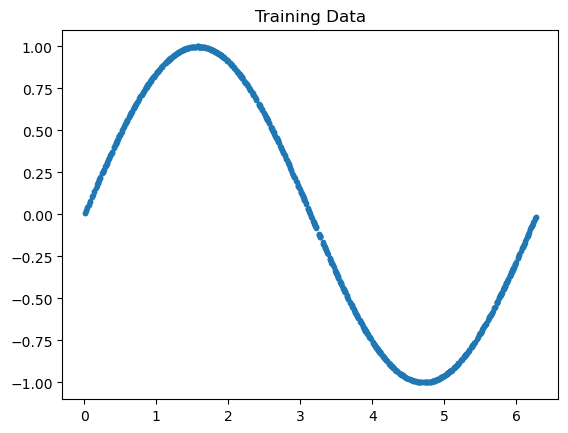

In [11]:
import math
generator = Generator()
discriminator = Discriminator()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = .0002)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = .0002)
loss_function = nn.BCELoss()

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
plt.plot(train_data[:, 0], train_data[:, 1], ".")
plt.title("Training Data")

In [12]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = batch_size, shuffle = True, num_workers = 0
)

num_epochs = 1000

Epoch: 0 Losss Discriminator: 0.4605,
Epoch: 0 Loss Generator : 0.6540


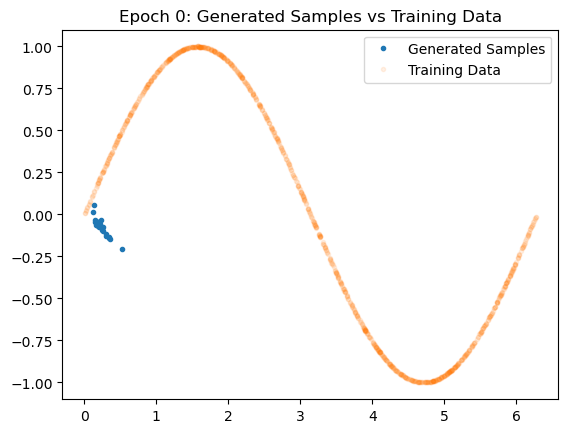

KeyboardInterrupt: 

In [13]:
losses = []
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples_labels = torch.ones((batch_size, 1)) # Labels for real samples, assigned as 1 to denote real data
        latent_space_samples = torch.randn((batch_size, 2)) # Random noise for generating fake samples
        generated_samples = generator(latent_space_samples) # Generating fake samples using the generator applied to the fake samples
        generatred_samples_labels = torch.zeros((batch_size, 1)) # Labels for generated samples, assigned as 0 to denote fake data
        all_samples = torch.cat((real_samples, generated_samples)) # Combining real and generated samples
        all_samples_labels = torch.cat( # Combining the labels for real and generated samples
            (real_samples_labels, generatred_samples_labels)
        )
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples) # Forward pass through the discriminator
        loss_discriminator = loss_function(output_discriminator, all_samples_labels) # Calculating the loss for the discriminator; Should learn to distinguish real from fake samples
        loss_discriminator.backward() # Backpropagation to compute gradients
        discriminator_optimizer.step() # Update the discriminator's weights
        
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 2))
        
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples) # Generating new samples using the random noise
        output_discriminator_generated = discriminator(generated_samples) # Forward pass through the discriminator to determine if the generated samples are real or fake
        loss_generator = loss_function( # Calculating the loss for the generator; Should learn to generate samples that the discriminator classifies as real
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        generator_optimizer.step()
        
        # Logging the loss
        if epoch % 100 == 0 and n == batch_size - 1:
            print(
                f"Epoch: {epoch} Losss Discriminator: {loss_discriminator.item():.4f},\n"
                f"Epoch: {epoch} Loss Generator : {loss_generator.item():.4f}"
            )
            losses.append((loss_discriminator.item(), loss_generator.item()))
            
        # Plotting the generated samples vs the training data every 200 epochs
        if epoch % 200 == 0 and n == batch_size - 1:
            plt.plot(
                generated_samples[:, 0].detach().numpy(),
                generated_samples[:, 1].detach().numpy(),
                ".", label = "Generated Samples"
            )
            plt.plot(
                train_data[:, 0].detach().numpy(),
                train_data[:, 1].detach().numpy(),
                ".", label = "Training Data",
                alpha = .1
            )
            plt.title(f"Epoch {epoch}: Generated Samples vs Training Data")
            plt.legend()
            plt.show()

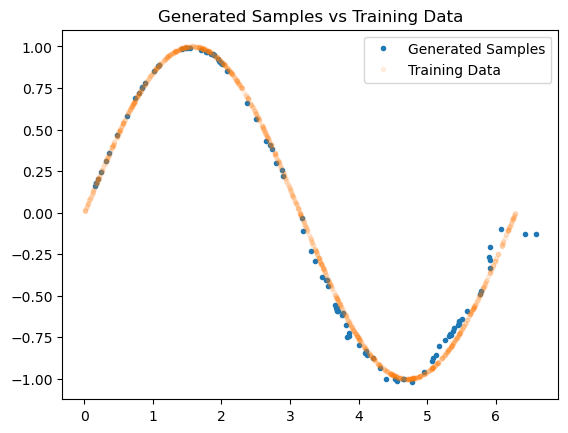

In [ ]:
latent_space_samples = torch.randn((100, 2))
generated_samples = generator(latent_space_samples).detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".", label = "Generated Samples")
plt.plot(train_data[:, 0], train_data[:, 1], ".", label = "Training Data", alpha=.1)
plt.title("Generated Samples vs Training Data")
plt.legend()

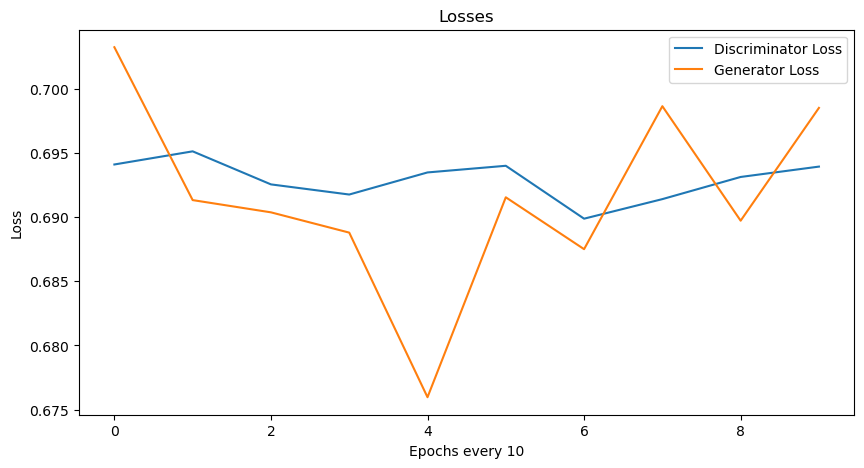

In [ ]:
# Plotting the losses
plt.figure(figsize = (10, 5))
plt.plot([x[0] for x in losses], label = "Discriminator Loss")
plt.plot([x[1] for x in losses], label = "Generator Loss")
plt.title("Losses")
plt.xlabel("Epochs every 10")
plt.ylabel("Loss")
plt.legend()
plt.show()

Applying this approach to the MNIST data set

In [89]:
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose( # transforms.ToTensor converts data to a PyTorch tensor
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))] # Normalizing the data
)
# Original coefficients given by transforms.ToTensor range from 1 to 1
# Most of the coefficients will be 0 when represented using this range
# transforms.Normalize will change the range to -1 to 1 by subtracting the coefficients and divdiing the result by .5
# We do this to ensure the data is centered around 0, which is important for training GANs

train_set = torchvision.datasets.MNIST( # Loading the MNIST dataset and applyiing the transform
    root=".", train=True, download=True, transform=transform
)

batch_size = 64
train_loader = torch.utils.data.DataLoader( # Creating a DataLoader for the MNIST dataset allowing us to iterate through the dataset in batches
    train_set, batch_size = batch_size, shuffle = True, num_workers = 0
)

Quick Visualization

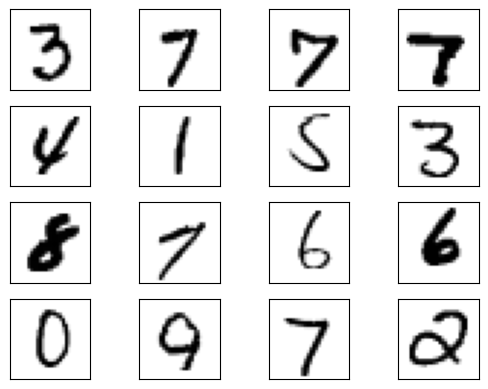

In [90]:
real_samples, mnist_labels = next(iter(train_loader)) # Getting a peak at the data
for i in range(16):
    ax = plt.subplot(4, 4, i + 1) # Creating a 4x4 grid of subplots
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r") # Reshaping the image and setting color to gray reversed
    plt.xticks([]) # Removing x ticks
    plt.yticks([]) # Removing y ticks

In [91]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024), # Input layer with 1024 neurons, 784 is the number of pixels in a 28x28 image
            nn.ReLU(), # We go to a higher dimension so we can learn more abstract representations that are difficult to model in lower-dimensional space
            nn.Dropout(.3),
            nn.Linear(1024, 512), # Hidden layer with 512 neurons
            nn.ReLU(),
            nn.Dropout(.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256), # Input of 100 to blow up 10 digits by 10
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh() # Tanh here is to take the values from -1 to 1
        )
        
    def forward(self, x):
        output = self.model(x) # Runs the forward pass
        output = output.view(x.size(0), 1, 28, 28) # [batch_size, channels, height, width]
        return output

In [ ]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

lr = .00001
num_epochs = 100
loss_function = nn.BCELoss() # Binary cross-entropy

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr = lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = lr)

losses = []
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        current_batch_size = real_samples.size(0)
        real_samples_labels = torch.ones((current_batch_size, 1)).to(device=device) # Giving the label of 1 to denote real data
        latent_space_samples = torch.randn((current_batch_size, 100)).to(device=device) # Generating noise
        generated_samples = generator(latent_space_samples) # forward pass through generator
        generated_samples_labels = torch.zeros((current_batch_size, 1)).to(device=device) # Giving the label of 0 to denote generated data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        # Data for training the generator
        latent_space_samples = torch.randn((current_batch_size, 100)).to(device=device)
        
        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()
        
        if n == current_batch_size - 1:
            print(f"Epoch: {epoch} Discriminator Loss: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Generator Loss: {loss_generator.item()}")
            
            losses.append((loss_discriminator.item(), loss_generator.item()))

Epoch: 0 Discriminator Loss: 0.5468072891235352
Epoch: 0 Generator Loss: 0.6591528654098511
Epoch: 1 Discriminator Loss: 0.2901747226715088
Epoch: 1 Generator Loss: 1.3350472450256348
Epoch: 2 Discriminator Loss: 0.10192519426345825
Epoch: 2 Generator Loss: 2.3956868648529053
Epoch: 3 Discriminator Loss: 0.06766483932733536
Epoch: 3 Generator Loss: 3.383784770965576
Epoch: 4 Discriminator Loss: 0.05135317146778107
Epoch: 4 Generator Loss: 3.767533779144287
Epoch: 5 Discriminator Loss: 0.033464305102825165
Epoch: 5 Generator Loss: 4.681882858276367
Epoch: 6 Discriminator Loss: 0.02134653739631176
Epoch: 6 Generator Loss: 5.319361686706543
Epoch: 7 Discriminator Loss: 0.013394957408308983
Epoch: 7 Generator Loss: 5.469803810119629
Epoch: 8 Discriminator Loss: 0.006767945364117622
Epoch: 8 Generator Loss: 6.654591083526611
Epoch: 9 Discriminator Loss: 0.0053902436047792435
Epoch: 9 Generator Loss: 6.555781364440918
Epoch: 10 Discriminator Loss: 0.013623157516121864
Epoch: 10 Generator Los

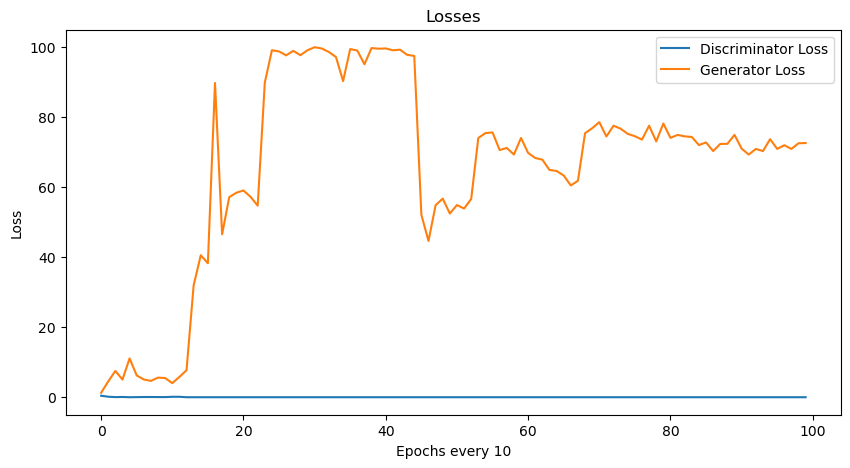

In [ ]:
# Plotting the losses
plt.figure(figsize = (10, 5))
plt.plot([x[0] for x in losses], label = "Discriminator Loss")
plt.plot([x[1] for x in losses], label = "Generator Loss")
plt.title("Losses")
plt.xlabel("Epochs every 10")
plt.ylabel("Loss")
plt.legend()
plt.show()

Checking the goods

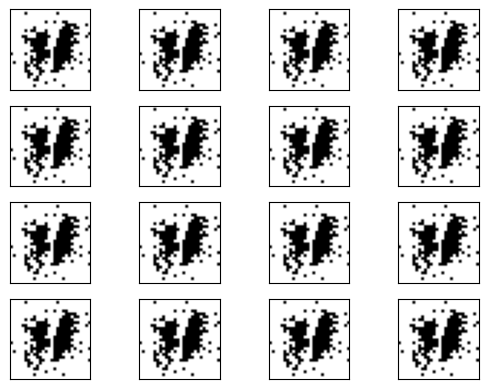

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28,28), cmap = "gray_r")
    plt.xticks([])
    plt.yticks([])

This is decent enough for vanilla GANs. Now let's try to do MCL-GAN.

First thing is to change the `batch_size` value. It's much more important in MCL-GAN, since we want each discriminator to learn effectively, and not get punished too much by a broader batch.

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader( # Creating a DataLoader for the MNIST dataset allowing us to iterate through the dataset in batches
    train_set, batch_size = batch_size, shuffle = True, num_workers = 0
)

# Main generator to be trained by all discriminators
new_generator = Generator()

gen_lr = 1e-4
disc_lr = 1e-3 # Using a lower learning rate for discriminators to balance out with the generator

# Group of discriminators that will learn to be specialized in their clusters
num_discriminators = 5
disc_list = [Discriminator() for _ in range(num_discriminators)]
disc_opt_list = [
    torch.optim.Adam(disc.parameters(), lr = disc_lr) for disc in disc_list
]

# Loss function will be utilized across all learners here
loss_function = nn.BCELoss()

gen_optimizer = torch.optim.Adam(new_generator.parameters(), lr=gen_lr)

In [ ]:
beta = 1.0 # regularization strength; static soft penalty on non-specialist
beta_d = .5 # Dynamic: decays each epoch to encourage specialization
tau = 1.0 # Hyperparameter for temperature

num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        current_batch_size = real_samples.size(0)
        real_samples_labels = torch.ones((current_batch_size, 1)).to(device=device) # Giving the label of 1 to denote real data
        latent_space_samples = torch.randn((current_batch_size, 100)).to(device=device) # Generating noise
        generated_samples = generator(latent_space_samples) # forward pass through generator
        generated_samples_labels = torch.zeros((current_batch_size, 1)).to(device=device) # Giving the label of 0 to denote generated data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        target_uniform = .5 * torch.ones_like(all_samples_labels) # make a uniform distribution whose shape matches that of all_samples_labels
        
        # Training the discriminators
        [disc.zero_grad() for disc in disc_list]
        disc_outputs = [discriminator(all_samples) for discriminator in disc_list]
        loss_values = [loss_function(disc_output, all_samples_labels) for disc_output in disc_outputs]
        min_loss = min(loss_values)
        min_index = torch.argmin(torch.tensor(loss_values))
        
        # CMCL Loss calculation
        total_loss = 0
        total_disc_loss = 0
        
        for index, (output, disc, optimizer) in enumerate(zip(disc_outputs, disc_list, disc_opt_list)):
            optimizer.zero_grad()
            
            if index == min_index: # The best discriminator gets the regular treatment
                loss = loss_function(output, all_samples_labels)
            else: # The others should approach uncertainty to discourage overconfidence
                loss = beta * nn.functional.binary_cross_entropy(output, target_uniform)
        
        # Applying softmax scores over all the discriminators' predictions for each sample batch
        disc_logits_for_q = torch.stack([output.squeeze(-1) for output in disc_outputs]).permute(1, 0)
        
        # Applying the softmax with temperature tau
        q_batch = torch.softmax(disc_logits_for_q/ tau, dim=1) # Ensure softmax is applied with the correct shape
        q = q_batch.mean(dim=0) # average across each batch towards the shape of M
        
        # Defining the target distribution mu (Uniform)
        mu = torch.full_like(q, 1.0/len(disc_list))
        
        # Computing the balanced loss
        disc_balance_loss = nn.functional.kl_div(q.log(), mu, reduction='batchmean') # Pushes q to uniform
        
        total_disc_loss += beta_d * disc_balance_loss
        [disc.zero_grad() for disc in disc_list]
        total_disc_loss.backward()
        
        # Apply optimizer steps
        for optimizer in disc_opt_list:
            optimizer.step()
        
        
        # Data for training the generator
        latent_space_samples = torch.randn((current_batch_size, 100)).to(device=device)
        
        # Training the generator
        new_generator.zero_grad()
        generated_samples = new_generator(latent_space_samples)
        output_discriminator_generated = disc_list[min_index](generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        gen_optimizer.step()
        
        # Update beta_d
        beta_d = max(.05, beta_d * .8)
        if n == current_batch_size - 1:
            print(f"Epoch: {epoch}")
            print(f"Best discriminator for this batch: Discriminator {min_index}")
            print(f"Best discriminator's loss this batch: {loss_values[min_index]}")
            print(f"Generator Loss: {loss_generator.item()}")
            
            losses.append((loss_values[min_index].item(), loss_generator.item()))
            
        # if epoch % 5 == 0:
        #     latent_space_samples = torch.randn(batch_size, 100).to(device=device)
        #     generated_samples = generator(latent_space_samples)
        #     generated_samples = generated_samples.cpu().detach()
        #     for i in range(16):
        #         ax = plt.subplot(4, 4, i+1)
        #         plt.imshow(generated_samples[i].reshape(28,28), cmap = "gray_r")
        #         plt.xticks([])
        #         plt.yticks([])
        #         plt.show()

Epoch: 0
Best discriminator for this batch: Discriminator 2
Best discriminator's loss this batch: 0.6863818168640137
Generator Loss: 0.3707779347896576
Epoch: 1
Best discriminator for this batch: Discriminator 2
Best discriminator's loss this batch: 0.6896566152572632
Generator Loss: 0.3756834864616394
Epoch: 2
Best discriminator for this batch: Discriminator 2
Best discriminator's loss this batch: 0.6911591291427612
Generator Loss: 0.390473872423172
Epoch: 3
Best discriminator for this batch: Discriminator 2
Best discriminator's loss this batch: 0.6918191313743591
Generator Loss: 0.3938363492488861
Epoch: 4
Best discriminator for this batch: Discriminator 2
Best discriminator's loss this batch: 0.6905092597007751
Generator Loss: 0.40839365124702454
Epoch: 5
Best discriminator for this batch: Discriminator 2
Best discriminator's loss this batch: 0.6913650035858154
Generator Loss: 0.4015684723854065
Epoch: 6
Best discriminator for this batch: Discriminator 2
Best discriminator's loss th

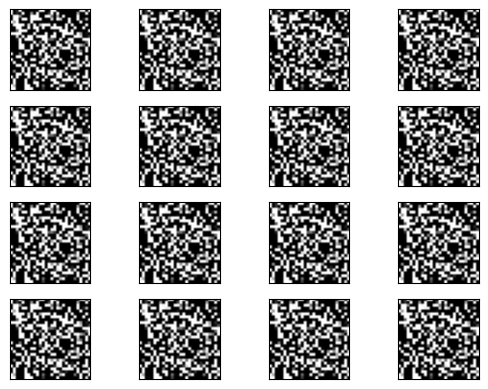

In [ ]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = new_generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28,28), cmap = "gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:

        # Integrating the Balanced loss into Discriminator training
        total_disc_loss += beta_d * disc_balance_loss
        total_disc_loss.backward()
        

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.